In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Callable

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from functools import partial
import numpy as np

import blackjax
import h5py
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import stats
import matplotlib.pyplot as plt
from jax import jit as jjit
from jax import random, vmap
from jax import random
from tqdm import tqdm

from jax import random

from bpd.measure import get_snr
from bpd.diagnostics import get_contour_plot
from bpd.chains import inference_loop

jax.config.update("jax_enable_x64", True)

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check target images

2024-11-01 13:56:05.863412: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(array([1196., 1158., 1136., 1018.,  975.,  829.,  728.,  637.,  498.,
         465.,  366.,  261.,  195.,  174.,  106.,   89.,   59.,   42.,
          24.,   25.,   11.,    3.,    3.,    0.,    2.]),
 array([0.        , 0.00014868, 0.00029736, 0.00044604, 0.00059472,
        0.0007434 , 0.00089208, 0.00104076, 0.00118944, 0.00133812,
        0.0014868 , 0.00163548, 0.00178416, 0.00193284, 0.00208152,
        0.0022302 , 0.00237888, 0.00252756, 0.00267624, 0.00282492,
        0.0029736 , 0.00312228, 0.00327096, 0.00341964, 0.00356832,
        0.003717  ]),
 <BarContainer object of 25 artists>)

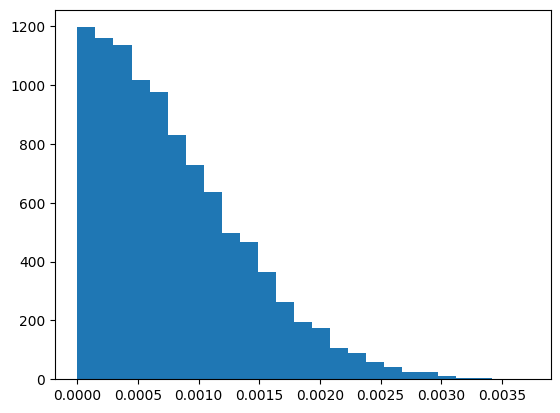

In [3]:
# look at prior samples for intuition
from bpd.prior import sample_mag_ellip_prior
emag_samples = sample_mag_ellip_prior(random.key(44), sigma=1e-3, n=10_000)
plt.hist(emag_samples, bins=25)

In [4]:
SEED = 43
rng_key = random.key(SEED)
pkey, nkey, k1 = random.split(rng_key, 3)

In [5]:
# setup
from bpd.pipelines.image_ellips import get_target_galaxy_params_simple

g1 = 0.02
g2 = 0.0
lf = 6.0 # 4.5=96, 6=1000
hlr = 1.0
sigma_e=1e-3
sigma_e_int = 3e-2 # size of at least shear!!
# sigma_e_int=2e-3
background = 1.0

galaxy_params = get_target_galaxy_params_simple(pkey, lf=lf, g1=g1, g2=g2, hlr=hlr, shape_noise=sigma_e)
galaxy_params

2024-11-01 13:57:03.180088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


{'lf': 6.0,
 'hlr': 1.0,
 'e1': Array(0.0002706, dtype=float64),
 'e2': Array(4.89806201e-05, dtype=float64),
 'x': 0.0,
 'y': 0.0,
 'g1': 0.02,
 'g2': 0.0}

In [6]:
from bpd.pipelines.image_ellips import get_target_images_single

draw_params = {**galaxy_params}
draw_params['f'] = 10**draw_params.pop('lf')

target_images, nn = get_target_images_single(nkey, 10, draw_params, background=background)
target_images.shape, nn.shape

((10, 53, 53), (53, 53))

SNR: 999.2646


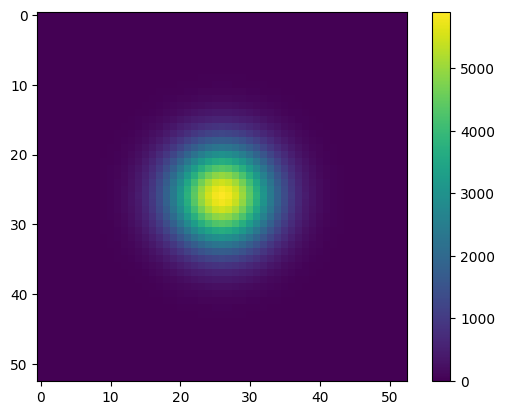

In [7]:
plt.imshow(target_images[0])
print('SNR:', get_snr(nn, background))
plt.colorbar()

In [8]:
# # how to initialize chains
# from bpd.initialization import init_with_truth
# init_fnc = vmap(init_with_truth, (0, None))

# # testing init function
# init_key, k2 = random.split(k1)
# init_keys = random.split(init_key, 10)
# init_positions = init_fnc(init_keys, galaxy_params)



In [9]:
from bpd.initialization import init_with_truth
init_fnc = init_with_truth

In [10]:
# true params should exclude g1, g2 and start on sheared ones. 
from bpd.prior import scalar_shear_transformation
true_params = {**galaxy_params}
e1, e2 = true_params.pop('e1'), true_params.pop('e2')
g1, g2 = true_params.pop('g1'), true_params.pop('g2')

e1_prime, e2_prime = scalar_shear_transformation((e1, e2), (g1, g2))
true_params['e1'] = e1_prime
true_params['e2'] = e2_prime

true_params

{'lf': 6.0,
 'hlr': 1.0,
 'x': 0.0,
 'y': 0.0,
 'e1': Array(0.02027049, dtype=float64),
 'e2': Array(4.89604979e-05, dtype=float64)}

In [11]:
# check it works on 1 image
from bpd.pipelines.image_ellips import pipeline_image_interim_samples
pipeline1 = partial(pipeline_image_interim_samples, 
                    initialization_fnc=init_fnc, 
                    background=background, 
                    initial_step_size=1e-3, 
                    n_samples=1000,
                   sigma_e_int=sigma_e_int,)
samples = pipeline1(k1, true_params, target_images[0])

In [12]:
samples['e1'].shape

(1000,)

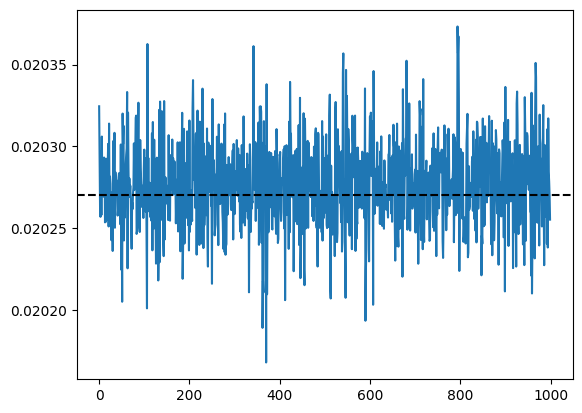

In [13]:
# check trace plots
plt.plot(samples['e1'])
plt.axhline(true_params['e1'], color='k', linestyle='--')

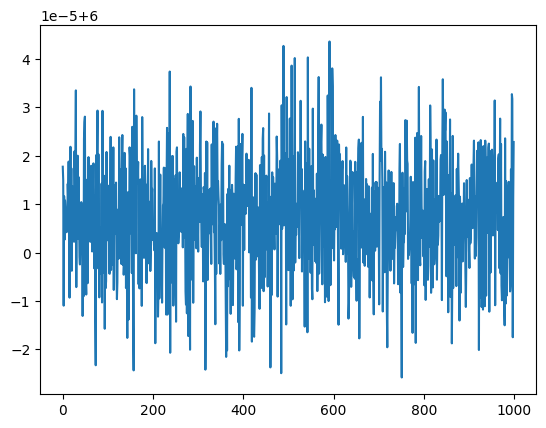

In [14]:
# check trace plots
plt.plot(samples['lf'])

## vmap, multiple galaxies

In [15]:
from bpd.initialization import init_with_truth
init_fnc = init_with_truth

In [16]:
# true params should exclude g1, g2 and start on sheared ones. 
from bpd.prior import scalar_shear_transformation
true_params = {**galaxy_params}
e1, e2 = true_params.pop('e1'), true_params.pop('e2')
g1, g2 = true_params.pop('g1'), true_params.pop('g2')

e1_prime, e2_prime = scalar_shear_transformation((e1, e2), (g1, g2))
true_params['e1'] = e1_prime
true_params['e2'] = e2_prime

true_params

{'lf': 6.0,
 'hlr': 1.0,
 'x': 0.0,
 'y': 0.0,
 'e1': Array(0.02027049, dtype=float64),
 'e2': Array(4.89604979e-05, dtype=float64)}

In [26]:
# try vmapping
_run_pipeline1 = partial(
    pipeline_image_interim_samples, 
    initialization_fnc=init_fnc,
    n_samples=1000,
    max_num_doublings=5,
    initial_step_size=1e-3,
    n_warmup_steps=500,
    is_mass_matrix_diagonal=False, 
    background=background,)

_run_pipeline = vmap(jjit(_run_pipeline1), (0, None, 0))
    


In [27]:
ikeys = random.split(k1, 10)

samples = _run_pipeline(ikeys, true_params, target_images)

In [32]:
jnp.stack( [samples['e1'], samples['e1']], axis=-1).shape

(10, 1000, 2)

In [28]:
samples['e1'].shape

(10, 1000)

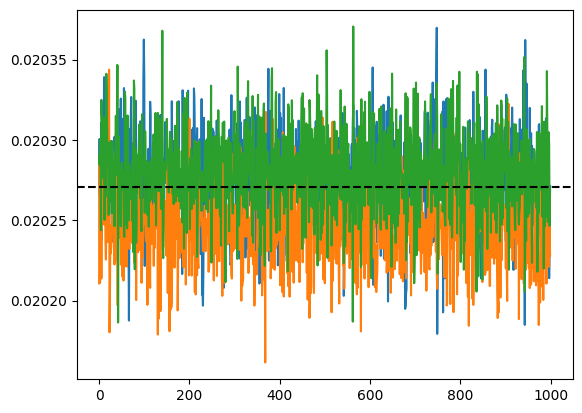

In [31]:
# check trace plots
plt.plot(samples['e1'][0])
plt.plot(samples['e1'][-1])
plt.plot(samples['e1'][-5])
plt.axhline(true_params['e1'], color='k', linestyle='--')